In [1]:
#things to be import

import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.autograd as atgd
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#loading training and testing data

batchsize = 16

transform = transforms.Compose(
    [
    transforms.Resize((32,32)),    
    transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.MNIST(root = './data/mnist', 
                           train = True, 
                           transform = transform,
                           download = True) 
test_dataset = torchvision.datasets.MNIST(root = './data/mnist',
                           train = False,
                           transform = transform,
                           download = True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=1)

print("The number of training images: ", len(train_loader)*batchsize)
print("The number of testing images: ", len(test_loader)*batchsize)


print("Data load OK!")

The number of training images:  60000
The number of testing images:  10000
Data load OK!


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)     
        self.conv3 = nn.Conv2d(16, 10, 5)


    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = self.conv3(x)
    
        return x

net = Net()

net = net.cuda()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 10, kernel_size=(5, 5), stride=(1, 1))
)


In [4]:
#training process

epoch_num = 5
x1 = range(1,epoch_num+1)
x2 = range(1,epoch_num+1)
accuracy1 = []
accuracy2 = []
loss1 = []
loss2 = []


for epoch in range(epoch_num): 
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        
        
        optimizer.zero_grad()     
        outputs = net(inputs)
        outputs = outputs.view(-1,10)
        
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()


    print("epoch number %d" % (epoch + 1))
    
    correct = 0
    total = 0
    running_loss = 0
    for data in train_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        
        
        
        outputs = net(images)
        outputs = outputs.view(-1,10)
        
        
        train_loss = criterion(outputs, labels)
        running_loss += train_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('train_accuracy: %.3f %%' % (100 * correct / total))
    accuracy1.append(100 * correct / total)
    print("train_loss: %.3f" % (running_loss / (len(train_loader)*batchsize) ))
    loss1.append(running_loss / (len(train_loader)*batchsize))
    
    # testing accuracy and loss
    correct = 0
    total = 0
    running_loss = 0
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs = net(images)
        outputs = outputs.view(-1,10)
        test_loss = criterion(outputs, labels)
        running_loss += test_loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += batchsize
        correct += (predicted == labels).sum().item()
       
    print('test_accuracy: %.3f %%' % (100 * correct / total))
    accuracy2.append(100 * correct / total)
    print("test_loss: %.3f" % (running_loss / (len(test_loader)*batchsize) ))
    loss2.append(running_loss / (len(test_loader)*batchsize))

print("Training OK!")




epoch number 1
train_accuracy: 96.253 %
train_loss: 0.008
test_accuracy: 96.510 %
test_loss: 0.007
epoch number 2
train_accuracy: 97.085 %
train_loss: 0.006
test_accuracy: 97.290 %
test_loss: 0.005
epoch number 3
train_accuracy: 98.027 %
train_loss: 0.004
test_accuracy: 98.170 %
test_loss: 0.004
epoch number 4
train_accuracy: 97.797 %
train_loss: 0.004
test_accuracy: 98.050 %
test_loss: 0.004
epoch number 5
train_accuracy: 98.280 %
train_loss: 0.003
test_accuracy: 98.220 %
test_loss: 0.004
Training OK!


torch.Size([1, 1, 64, 64])
torch.Size([1, 10, 9, 9])
torch.Size([10, 9, 9])
tensor([[ 1.2413, -3.2068,  1.2799,  5.9499,  4.5268,  1.8398, -0.6316,
         -2.2545, -3.5705],
        [-3.5990, -5.4145, -0.4457,  3.2490,  1.6206,  1.2005,  0.0797,
         -3.8991, -5.9117],
        [-3.0495, -7.2716, -8.9217, -4.9140, -0.7396,  4.3376,  1.7738,
         -6.2941, -5.4239],
        [-5.9049, -6.7104, -7.2233, -6.1277, -3.6347,  0.8986, -1.7694,
         -6.4002, -5.2327],
        [-6.2304,  0.8620,  1.0338, -1.7776, -2.1883, -0.9903, -3.9781,
         -6.6703, -4.6337],
        [-7.2179,  3.1661,  4.9968,  0.3020, -1.4734,  0.7684, -2.9703,
         -8.7954, -8.0181],
        [-0.5992,  1.1123,  0.4640, -0.7641, -0.2616,  1.4819, -0.5243,
         -8.1364, -9.1480],
        [ 4.6342, -1.3410, -3.3141, -0.3559,  1.2756,  2.8953,  3.5107,
         -3.1455, -8.4803],
        [ 6.6129,  4.8699, -0.9729,  0.0049,  0.1222,  2.5862,  5.3225,
         -2.0043, -8.8586]], device='cuda:0')


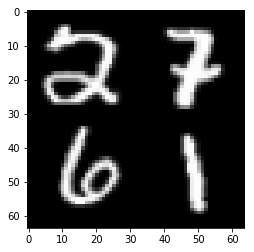

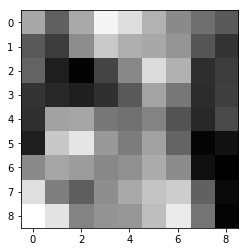

In [8]:
combine_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

for data in combine_loader:
    images, _ = data
    images = images.cuda()

    combine = torch.cat((torch.cat((images[0], images[1]),1) , torch.cat((images[2], images[3]),1)),2)
    combine = combine.view(1,1,64,64)
    print(combine.size())
    plt.figure(0)
    plt.imshow(combine.squeeze(), cmap = "gray")
    
    
    outputs = net(combine)
    print(outputs.size())
    
    outputs = outputs.squeeze()
    print(outputs.size())
    plt.figure(1)
    plt.imshow(outputs[0].detach(), cmap="gray")
    print(outputs[0])
    break
#     print(images.size())